In [6]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'student-grade-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F52721%2F99691%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240325%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240325T081806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D80b7e0d422a766204959d448d481df54d81287335e6baa38c762a66e7ea2a430390a669ed90c6677d00c015850e432eace1d80d5884ce82dd1ce06c0d83d42b7a46389ca67147c5e206d837b7c7b205d853b15979d9ac04296b79b7a8355c68f478f416a5a5a127fa4fa0f7844e8bec0e3aed0b73fd3d7d4e2b687e1cecc7e8468a309699ed8196d320d2fdf507c826b3f4d37722f9de4de49cc5065d20554f20c12b53886332810d9b26066c4a1aa73ef6d0d36241d3b8f16f64b4e3671d844187908e53baa6a4ca49f770135997babc06c12c6ec0872ea2bb8c85ec1a447176d09034c0e09aa9ab1bd3f85d55a5f3285f934a38a5411a3b2d9faf9943e3acd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7328 bytes downloaded
Downloaded and uncompressed: student-grade-prediction
Data source import complete.


**Student Grade Prediction**


> **Importing Required Libraries**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import *
from wordcloud import *
from sklearn import *
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import *
from sklearn.tree import *
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import *
from sklearn.metrics import *
%matplotlib inline

> **Import and read the data**

In [8]:
student_data=pd.read_csv('../input/student-grade-prediction/student-mat.csv')
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [9]:
print(f"Lenght: {len(student_data)}")
print(f"Shape: {student_data.shape}")
print(f"Columns: {student_data.columns}")

Lenght: 395
Shape: (395, 33)
Columns: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


> **Explore data**

In [10]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

> **Visualize**

In [ ]:
student_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


> **Cleaning data**

In [ ]:
student_data.isnull().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

> **Analyze**

In [ ]:
student_data.drop('famsize',axis=1,inplace=True)
student_data.head()

,school,sex,age,address,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,A,4,4,at_home,teacher,course,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,T,1,1,at_home,other,course,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,T,1,1,at_home,other,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,T,4,2,health,services,home,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,T,3,3,other,other,home,...,4,3,2,1,2,5,4,6,10,10


> **Filter only numerical columns**

In [ ]:
numerical_columns = student_data.select_dtypes(include='number')

> **Display the resulting DataFrame with only numerical columns**

In [ ]:
print(numerical_columns)

     age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0     18     4     4           2          2         0       4         3   
1     17     1     1           1          2         0       5         3   
2     15     1     1           1          2         3       4         3   
3     15     4     2           1          3         0       3         2   
4     16     3     3           1          2         0       4         3   
..   ...   ...   ...         ...        ...       ...     ...       ...   
390   20     2     2           1          2         2       5         5   
391   17     3     1           2          1         0       2         4   
392   21     1     1           1          1         3       5         5   
393   18     3     2           3          1         0       4         4   
394   19     1     1           1          1         0       3         2   

     goout  Dalc  Walc  health  absences  G1  G2  G3  
0        4     1     1       3         6   5

In [ ]:
numerical_columns.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660


In [11]:
best_features=['studytime','failures', 'absences', 'G1', 'G2']

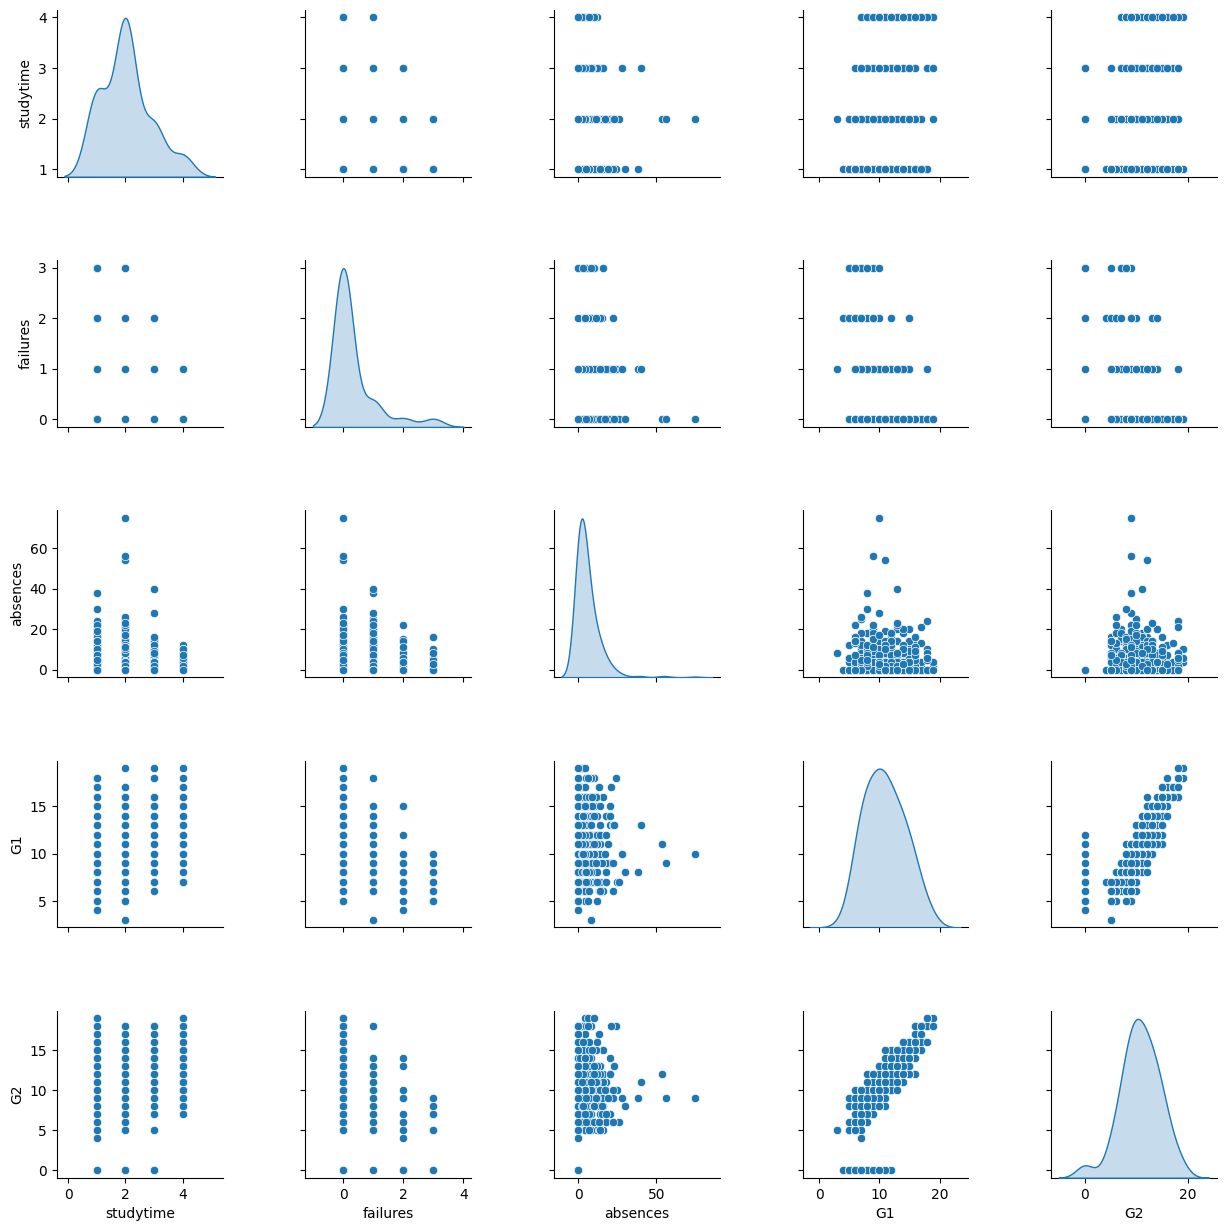

In [12]:
sns.pairplot(student_data[best_features], kind='scatter', diag_kind='kde', diag_kws={'bw_adjust': 1.5})
plt.subplots_adjust(hspace=0.5, wspace=0.5)


> **Visualize results**

In [13]:
student_data.groupby('school')['G1'].mean()

school
GP    10.939828
MS    10.673913
Name: G1, dtype: float64

In [14]:
student_data.groupby('school')['G1'].count()


school
GP    349
MS     46
Name: G1, dtype: int64

In [15]:
student_data['mean_periods'] = (student_data.G1 + student_data.G2 + student_data.G3) / 3

(array([10., 17., 33., 43., 76., 73., 62., 52., 16., 13.]),
 array([ 1.33333333,  3.13333333,  4.93333333,  6.73333333,  8.53333333,
        10.33333333, 12.13333333, 13.93333333, 15.73333333, 17.53333333,
        19.33333333]),
 <BarContainer object of 10 artists>)

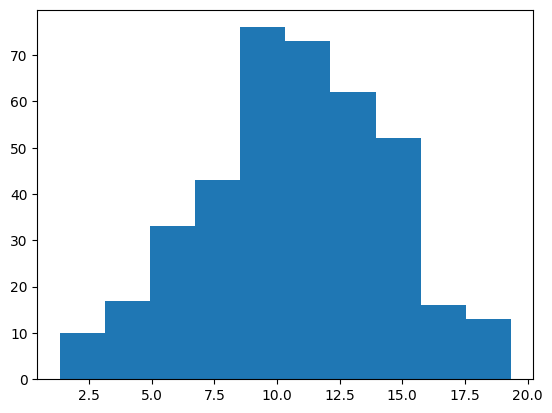

In [ ]:
plt.hist(student_data.mean_periods)

> *Boys spend less time on studying than girls*
>

<Axes: xlabel='studytime', ylabel='mean_periods'>

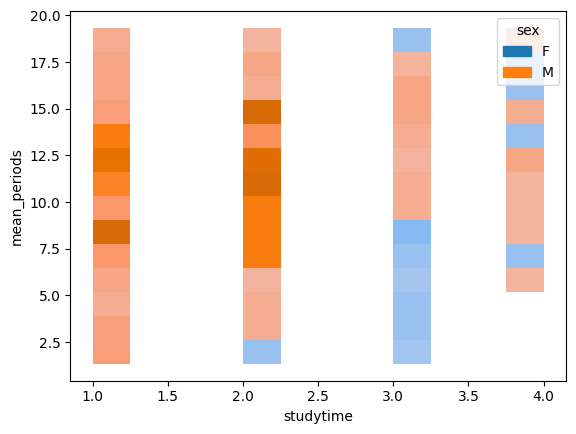

In [16]:
sns.histplot(data=student_data, x='studytime', y='mean_periods', hue='sex')


In general boys study better than girls



In [17]:
student_data.groupby('sex')['mean_periods'].mean()

sex
F    10.325321
M    11.073084
Name: mean_periods, dtype: float64

Internet improves your marks



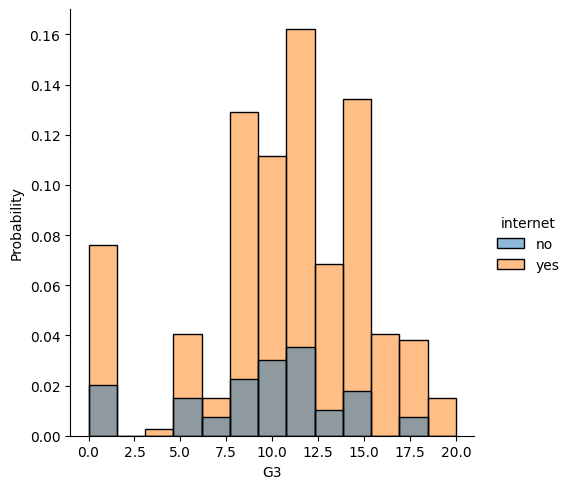

In [18]:
sns.displot(x='G3', hue='internet',data=student_data,stat='probability')

Students who don't take paid classes have better marks



<Axes: xlabel='paid', ylabel='G3'>

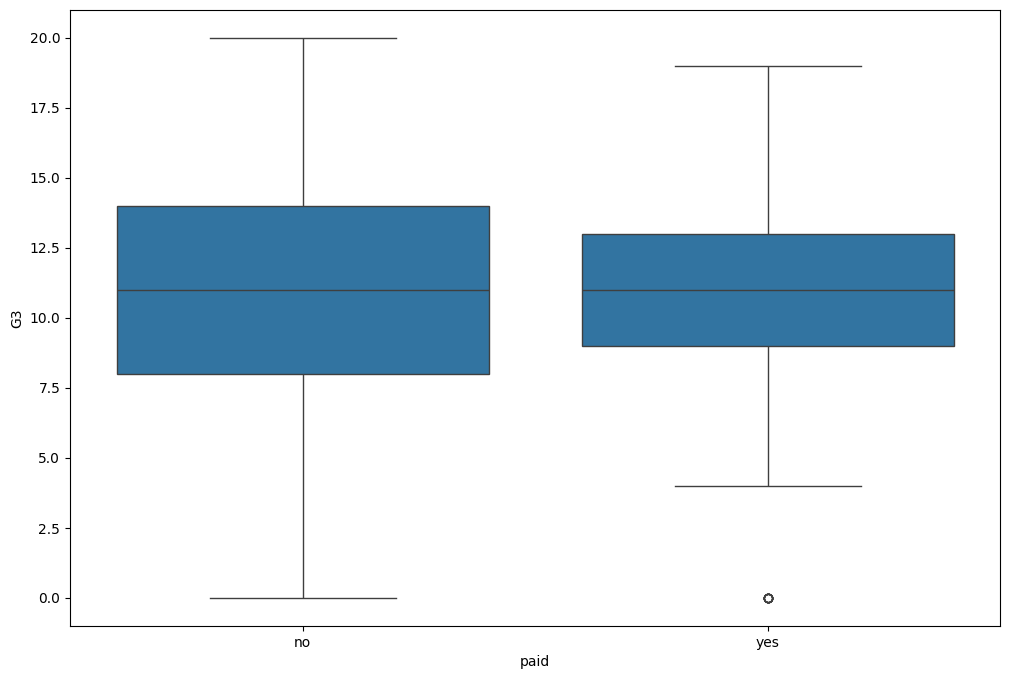

In [19]:
plt.figure(figsize=[12,8])
sns.boxplot(x='paid', y='G3', data=student_data)

Encoding variables

In [20]:
category_student_data = student_data.select_dtypes(include=['object'])

In [21]:
student_data_dummy = pd.get_dummies(category_student_data)


In [22]:
student_data_dummy['G3'] = student_data['G3']

In [23]:
student_data_dummy.corr()['G3'].sort_values(ascending=False)

G3                   1.000000
higher_yes           0.182465
romantic_no          0.129970
Mjob_health          0.116158
address_U            0.105756
sex_M                0.103456
paid_yes             0.101996
internet_yes         0.098483
reason_reputation    0.095692
Fjob_teacher         0.095374
schoolsup_no         0.082788
famsize_LE3          0.081407
Mjob_services        0.078429
Pstatus_A            0.058009
Mjob_teacher         0.057712
Fjob_health          0.057111
reason_other         0.052008
nursery_yes          0.051568
school_GP            0.045017
famsup_no            0.039157
guardian_father      0.032493
guardian_mother      0.022338
activities_yes       0.016100
Fjob_at_home        -0.013385
activities_no       -0.016100
Fjob_services       -0.016108
reason_home         -0.021359
famsup_yes          -0.039157
school_MS           -0.045017
nursery_no          -0.051568
Fjob_other          -0.053483
Pstatus_T           -0.058009
famsize_GT3         -0.081407
schoolsup_

In [24]:
y = student_data['G3']

X = student_data.drop(['G1', 'G2', 'mean_periods', 'school'], axis=1)

X = pd.get_dummies(X)

In [25]:
most_correlated = X.corr().abs()['G3'].sort_values(ascending=False)

Students whose parents have better education score higher



<Axes: xlabel='Medu', ylabel='G3'>

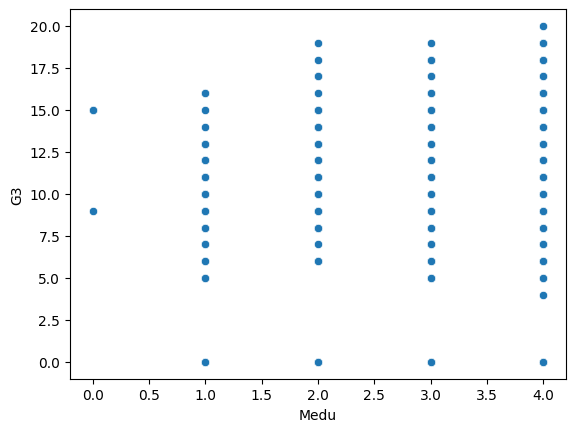

In [26]:
sns.scatterplot(x='Medu', y='G3', data=X)

<Axes: xlabel='Fedu', ylabel='G3'>

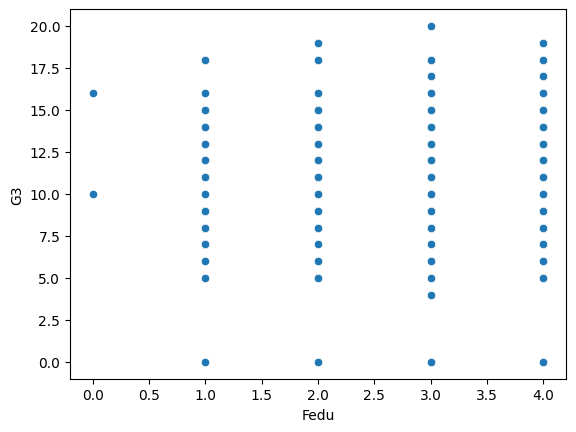

In [27]:
sns.scatterplot(x='Fedu', y='G3', data=X)


Age does not affect score



<Axes: xlabel='age', ylabel='G3'>

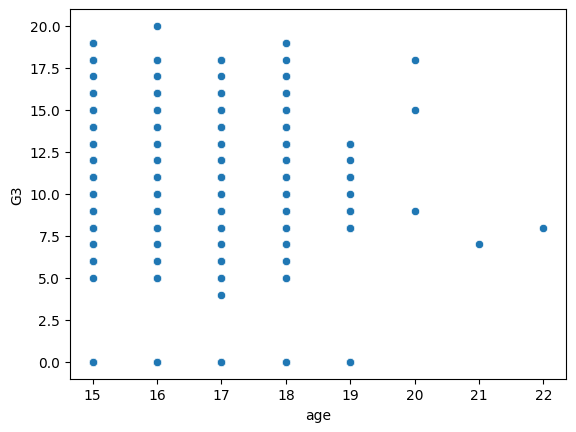

In [28]:
sns.scatterplot(data=X, x='age', y='G3')


Students who want to take higher education score better

<Axes: xlabel='higher_yes', ylabel='count'>

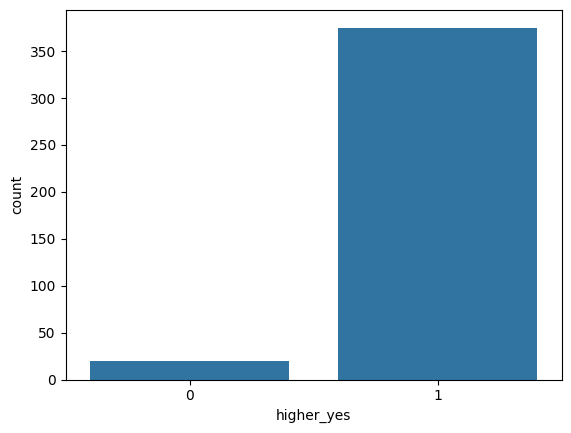

In [29]:
sns.countplot(data=X, x='higher_yes')

Students who do not have romantic relat. score better



<Axes: xlabel='romantic_no', ylabel='count'>

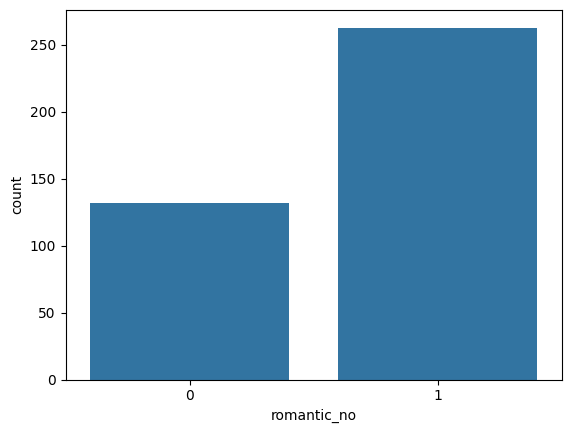

In [30]:
sns.countplot(data=X, x='romantic_no')

Internet improves your marks

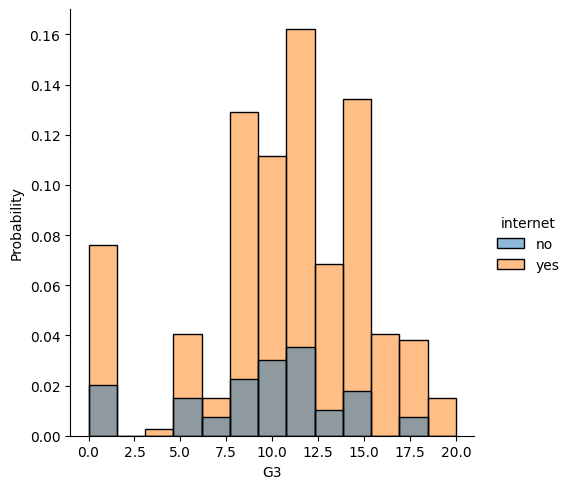

In [31]:
sns.displot(x='G3',
           hue='internet',
           data=student_data,
           stat='probability')

Students who don't take paid classes have better marks


<Axes: xlabel='paid', ylabel='G3'>

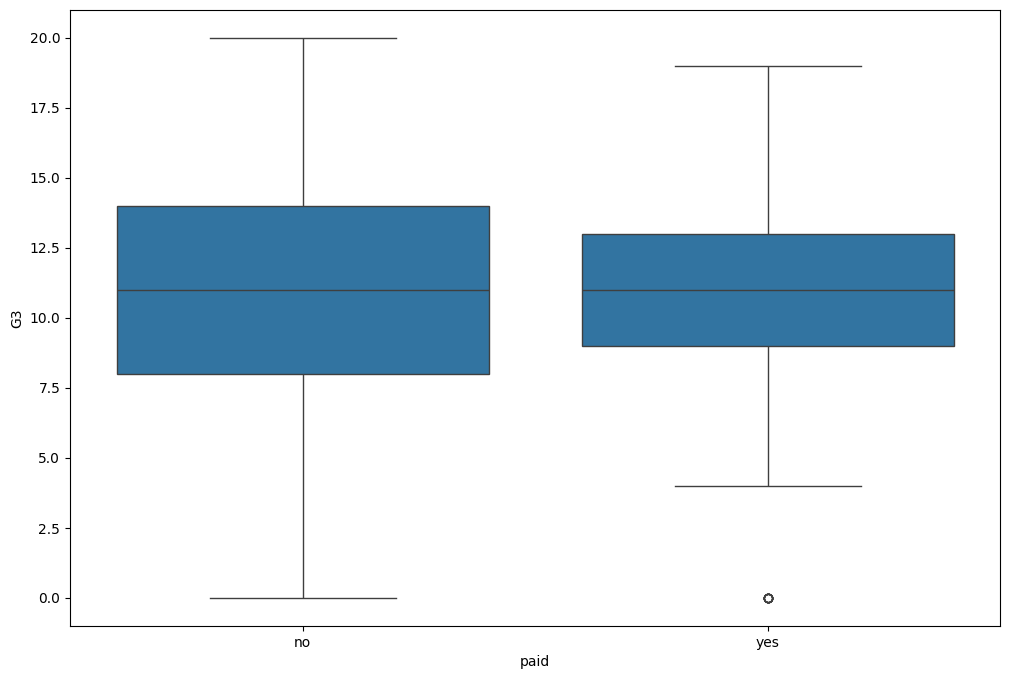

In [32]:
plt.figure(figsize=[12,8])
sns.boxplot(x='paid', y='G3', data=student_data)